In [7]:
import requests
import pandas as pd

In [8]:
server_name = 'http://localhost:3030'
service_name = 'ds'
request_url = server_name + '/' + service_name

## Getting familiar with the data

In [247]:
query = '''
PREFIX a: <http://www.semanticweb.org/alicia/ontologies/2020/8/singleCellRepositories#> 
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
SELECT
    ?projectTitle
    ?repository
    ?projectSpecimens
    (COUNT(*) AS ?numSpecimens)
    (SUM(?numCells) AS ?numTotalCells)
WHERE
{
    ?specimenID rdf:type a:Specimen ;
                a:SPR.hasSpecie a:HomoSapiens ;
                a:SPR.hasMinAge ?minAge ;
                a:SPR.hasOrganismPart a:Blood ;
                a:SPR.hasProjectTitle ?projectTitle ;
                a:SPR.isPartOfRepository ?repository ;
                a:SPR.hasTotalCellCount ?numCells .
    ?projectID rdf:type a:Project ;
               a:SPR.hasProjectTitle ?projectTitle ;
               a:PR.hasSpecimenCount ?projectSpecimens
    FILTER (?numCells != -1) .
    FILTER (?minAge > 17) .
}
GROUP BY ?projectTitle ?repository ?projectSpecimens
ORDER BY ?numTotalCells
'''

In [248]:
response = requests.post(request_url,
       data={'query': query})

# print(response.text)

headers = response.json()["head"]["vars"]
results = response.json()["results"]

rows = []

for result in response.json()["results"]["bindings"]:
    result_dict = {}
    for header in headers:
        result_dict[header] = result[header]['value']
        
    rows.append(result_dict)

df = pd.DataFrame(rows)
df

,projectTitle,repository,projectSpecimens,numSpecimens,numTotalCells
0,Transcriptomic profiling of antigen-specific T...,SingleCellExpresionAtlas,2,2,72
1,Single cell RNA-sequencing of PBMC derived B c...,SingleCellExpresionAtlas,1,1,117
2,Single-cell RNAseq of Human T lymphocyte deriv...,SingleCellExpresionAtlas,2,2,119
3,Single cell RNA seq of influenza tetramer spec...,SingleCellExpresionAtlas,1,1,210
4,Precursors of human CD4+ cytotoxic T lymphocyt...,HumanCellAtlas,28,28,2244
5,RNA-seq of RBC depleted whole blood from COVID...,SingleCellExpresionAtlas,7,6,5977
6,Immune landscape of viral- and carcinogen-deri...,SingleCellExpresionAtlas,63,32,61675
7,A single-cell atlas of the peripheral immune r...,SingleCellExpresionAtlas,12,12,92783


## Common metadata between projects

In [9]:
query = '''
PREFIX a: <http://www.semanticweb.org/alicia/ontologies/2020/8/singleCellRepositories#> 
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
SELECT
    ?projectID
    ?projectTitle
    ?repository
    (COUNT(*) AS ?numSpecimens)
    (SUM(?numCells) AS ?numTotalCells)
    ?relation
WHERE
{
    ?specimenID rdf:type a:Specimen ;
                a:SPR.hasSpecie a:HomoSapiens ;
                a:SPR.hasMinAge ?minAge ;
                a:SPR.hasOrganismPart a:Blood ;
                a:SPR.hasProjectTitle ?projectTitle ;
                a:SPR.isPartOfRepository ?repository ;
                a:SPR.hasTotalCellCount ?numCells ;
                ?relation ?value .
    ?project rdf:type a:Project ;
             a:SPR.hasProjectTitle ?projectTitle ;
             a:PR.hasProjectID ?projectID .
    FILTER (?numCells != -1) .
    FILTER (?minAge > 17) .
}
GROUP BY ?projectID ?projectTitle ?repository ?relation
'''

In [10]:
response = requests.post(request_url,
       data={'query': query})

# print(response.text)

headers = response.json()["head"]["vars"]
results = response.json()["results"]

rows = []

for result in response.json()["results"]["bindings"]:
    result_dict = {}
    for header in headers:
        result_dict[header] = result[header]['value']
        
    rows.append(result_dict)

df = pd.DataFrame(rows)

In [11]:
df["numTotalCells"] = pd.to_numeric(df["numTotalCells"])
df['relation'] = df['relation'].apply(lambda x: x.split('#')[1])
df = df.sort_values(by=['projectTitle'], ascending=False)
df

,projectID,projectTitle,repository,numSpecimens,numTotalCells,relation
66,E-MTAB-4850,Transcriptomic profiling of antigen-specific T...,SingleCellExpresionAtlas,2,72,SPR.hasOrganismPart
61,E-MTAB-4850,Transcriptomic profiling of antigen-specific T...,SingleCellExpresionAtlas,2,72,SPR.hasTotalCellCount
117,E-MTAB-4850,Transcriptomic profiling of antigen-specific T...,SingleCellExpresionAtlas,2,72,SPR.isPartOfRepository
46,E-MTAB-4850,Transcriptomic profiling of antigen-specific T...,SingleCellExpresionAtlas,2,72,SPR.hasMaxAge
114,E-MTAB-4850,Transcriptomic profiling of antigen-specific T...,SingleCellExpresionAtlas,2,72,SPR.hasSpecie
...,...,...,...,...,...,...
38,E-GEOD-150728,A single-cell atlas of the peripheral immune r...,SingleCellExpresionAtlas,12,92783,SPR.isPartOfCollection
34,E-GEOD-150728,A single-cell atlas of the peripheral immune r...,SingleCellExpresionAtlas,12,92783,type
17,E-GEOD-150728,A single-cell atlas of the peripheral immune r...,SingleCellExpresionAtlas,12,92783,SPR.hasCellType
6,E-GEOD-150728,A single-cell atlas of the peripheral immune r...,SingleCellExpresionAtlas,12,92783,SPR.hasMinAge


In [254]:
all_columns = set()
for project_title in df['projectTitle'].unique():
    project_columns = df[df['projectTitle'] == project_title]['relation']
    all_columns.update(list(project_columns))

all_columns.remove('type')

print(all_columns)

{'SPR.hasTotalCellCount', 'SR.hasSpecimenID', 'SPR.hasSpecie', 'SPR.hasSampleType', 'SPR.hasMinAge', 'SPR.hasAgeUnit', 'SPR.hasTotalSizeOfFilesInMB', 'SPR.hasInstrument', 'SPR.isPartOfCollection', 'SPR.hasMaxAge', 'SPR.hasPreservation', 'SPR.hasProjectTitle', 'SPR.hasOrganismPart', 'SPR.hasBiopsySite', 'SPR.hasDisease', 'SPR.hasLaboratory', 'SPR.hasCellType', 'SPR.isPartOfRepository', 'SPR.hasProjectShortName', 'SPR.hasSex', 'SPR.isPairedEnd', 'SPR.hasLibrary'}


In [88]:
df_relations = pd.DataFrame(columns= ['project_title'] + list(all_columns))

for project_title in df['projectTitle'].unique():
    project_columns = df[df['projectTitle'] == project_title]['relation']
    row = dict(zip(['project_title'] + list(all_columns) , [project_title] + [False] * len(all_columns)))
    for project_column in project_columns:
        row[project_column] = True
        
    df_relations = df_relations.append(row, ignore_index=True)
df_relations = df_relations.drop(['type'], axis=1)
df_relations

,project_title,SPR.hasTotalCellCount,SR.hasSpecimenID,SPR.hasSpecie,SPR.hasSampleType,SPR.hasMinAge,SPR.hasAgeUnit,SPR.hasTotalSizeOfFilesInMB,SPR.hasInstrument,SPR.isPartOfCollection,...,SPR.hasOrganismPart,SPR.hasBiopsySite,SPR.hasDisease,SPR.hasLaboratory,SPR.hasCellType,SPR.isPartOfRepository,SPR.hasProjectShortName,SPR.hasSex,SPR.isPairedEnd,SPR.hasLibrary
0,Transcriptomic profiling of antigen-specific T...,True,False,True,True,True,True,True,False,False,...,True,False,True,False,True,True,False,True,False,False
1,Single-cell RNAseq of Human T lymphocyte deriv...,True,True,True,True,True,True,True,False,False,...,True,False,True,False,True,True,False,True,False,False
2,Single cell RNA-sequencing of PBMC derived B c...,True,True,True,True,True,True,True,False,False,...,True,False,True,False,True,True,False,True,False,False
3,Single cell RNA seq of influenza tetramer spec...,True,True,True,True,True,True,True,False,False,...,True,False,False,False,True,True,False,True,False,False
4,RNA-seq of RBC depleted whole blood from COVID...,True,True,True,True,True,True,True,False,True,...,True,False,True,False,False,True,False,True,False,False
5,Precursors of human CD4+ cytotoxic T lymphocyt...,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
6,Immune landscape of viral- and carcinogen-deri...,True,True,True,True,True,True,True,False,False,...,True,True,True,False,True,True,False,True,False,False
7,A single-cell atlas of the peripheral immune r...,True,True,True,True,True,True,True,False,True,...,True,False,True,False,True,True,False,True,False,False


In [89]:
df_relations.all()

project_title                   True
SPR.hasTotalCellCount           True
SR.hasSpecimenID               False
SPR.hasSpecie                   True
SPR.hasSampleType               True
SPR.hasMinAge                   True
SPR.hasAgeUnit                  True
SPR.hasTotalSizeOfFilesInMB     True
SPR.hasInstrument              False
SPR.isPartOfCollection         False
SPR.hasMaxAge                   True
SPR.hasPreservation            False
SPR.hasProjectTitle             True
SPR.hasOrganismPart             True
SPR.hasBiopsySite              False
SPR.hasDisease                 False
SPR.hasLaboratory              False
SPR.hasCellType                False
SPR.isPartOfRepository          True
SPR.hasProjectShortName        False
SPR.hasSex                      True
SPR.isPairedEnd                False
SPR.hasLibrary                 False
dtype: bool

In [87]:
intersect_columns = set()
for project_title in df['projectTitle'].unique():
    project_columns = df[df['projectTitle'] == project_title]['relation']
    
    if not intersect_columns:
        intersect_columns = set(project_columns)
        continue
    
    intersect_columns = intersect_columns.intersection(set(project_columns))
    
intersect_columns.remove('type')
    
print(intersect_columns)

{'SPR.hasTotalCellCount', 'SPR.hasTotalSizeOfFilesInMB', 'SPR.isPartOfRepository', 'SPR.hasSpecie', 'SPR.hasMaxAge', 'SPR.hasSex', 'SPR.hasSampleType', 'SPR.hasMinAge', 'SPR.hasAgeUnit', 'SPR.hasProjectTitle', 'SPR.hasOrganismPart'}


## Download the data from the projects

In [13]:
def get_data(project):
    query = '''
        PREFIX a: <http://www.semanticweb.org/alicia/ontologies/2020/8/singleCellRepositories#> 
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        SELECT 
            ?normalisedCountsLink
        WHERE
        {
        '''\
        + \
        f'''
            ?projectID rdf:type a:Project ;
                       a:SPR.hasProjectTitle "{project}" ;
                       a:SPR.hasNormalisedCountsLink ?normalisedCountsLink .
        '''\
        +\
        '''      
        }
    '''
    response = requests.post(request_url,
       data={'query': query})
    
    if response.json()['results']['bindings']:
        return response.json()['results']['bindings'][0]['normalisedCountsLink']['value']
    else:
        return None
    

In [14]:
from pprint import pprint

download_links = []

for project_title, project_id in zip(df['projectTitle'].unique(), df['projectID'].unique()):
    print(project_title)
    print(project_id)
    response = get_data(project_title)
    download_links.append({
        'project_title': project_title,
        'project_id': project_id,
        'link': response
    })
    print(response)

Transcriptomic profiling of antigen-specific T cells at the single-cell level after clearance of hepatitis C virus
E-MTAB-4850
https://www.ebi.ac.uk/gxa/sc/experiment/E-MTAB-4850/download/zip?fileType=normalised&accessKey=
Single-cell RNAseq of Human T lymphocyte derived from H7N9 infected patients
E-MTAB-6379
https://www.ebi.ac.uk/gxa/sc/experiment/E-MTAB-6379/download/zip?fileType=normalised&accessKey=
Single cell RNA-sequencing of PBMC derived B cells from human healthy donor
E-MTAB-6386
https://www.ebi.ac.uk/gxa/sc/experiment/E-MTAB-6386/download/zip?fileType=normalised&accessKey=
Single cell RNA seq of influenza tetramer specific CD8+ T cells from baseline, acute and long term memory timepoints
E-MTAB-7606
https://www.ebi.ac.uk/gxa/sc/experiment/E-MTAB-7606/download/zip?fileType=normalised&accessKey=
RNA-seq of RBC depleted whole blood from COVID-19 patients and controls
E-MTAB-9221
https://www.ebi.ac.uk/gxa/sc/experiment/E-MTAB-9221/download/zip?fileType=normalised&accessKey=
Pre

In [269]:
import zipfile
import os

path_to_links = 'blood_downloads/'

for project in download_links:
        
    if project['link'] is None:
        continue
    
    print('Downloading project ' + project['project_id'])
    
    # download the file contents in binary format
    response = requests.get(project['link'])
    
    zip_name = path_to_links + project['project_id'] + ".zip"
    
    # open method to open a file on your system and write the contents
    with open(zip_name, "wb") as code:
        code.write(response.content)
        
    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extract(project['project_id'] + '.aggregated_filtered_normalised_counts.mtx', path=path_to_links)
        
    os.remove(zip_name)

## Clustering with PCA

In [2]:
import matplotlib.pyplot as plt

from scipy.io import mmread
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Test with small matrix

In [3]:
small_matrix = mmread('../SingleCell-Files/blood_downloads/E-MTAB-4850.aggregated_filtered_normalised_counts.mtx')
scaled_small_matrix = StandardScaler().fit_transform(small_matrix.toarray())
scaled_small_matrix.shape

(15912, 63)

In [15]:
pca = PCA(n_components=2)
projected = pca.fit_transform(scaled_small_matrix)
projected.shape

(15912, 2)

Text(0.5, 1.0, 'PCA projection of the small matrix')

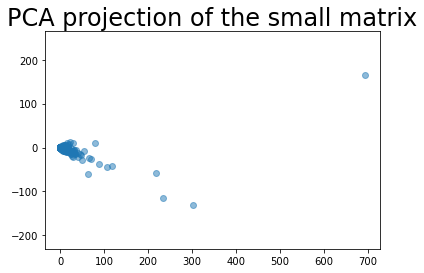

In [16]:
plt.scatter(
    projected[:, 0],
    projected[:, 1],
    alpha=0.5
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('PCA projection of the small matrix', fontsize=24)

### Test with large matrix

In [ ]:
large_matrix = mmread('../SingleCell-Files/blood_downloads/E-GEOD-139324.aggregated_filtered_normalised_counts.mtx')
scaled_large_matrix = StandardScaler().fit_transform(large_matrix.toarray())
scaled_large_matrix.shape

In [ ]:
pca = PCA(n_components=2)
projected = pca.fit_transform(large_matrix.toarray())
projected.shape

In [ ]:
plt.scatter(
    projected[:, 0],
    projected[:, 1],
    alpha=0.5
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('PCA projection of the small matrix', fontsize=24)

## Clustering with UMAP

In [1]:
import umap
import matplotlib.pyplot as plt

from scipy.io import mmread
from sklearn.preprocessing import StandardScaler

/Users/edusalcas/opt/anaconda3/envs/work/lib/python3.8/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


### Test with small matrix

In [2]:
matrix = mmread('../SingleCell-Files/blood_downloads/E-MTAB-4850.aggregated_filtered_normalised_counts.mtx')
scaled_matrix = StandardScaler().fit_transform(matrix.toarray())
scaled_matrix.shape

(15912, 63)

In [3]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_matrix)
embedding.shape

(15912, 2)

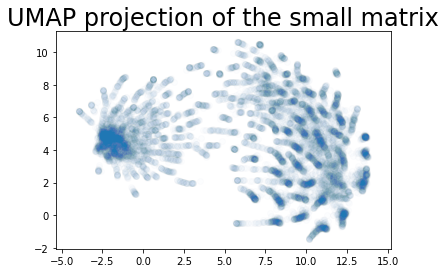

In [5]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    alpha=0.01
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the small matrix', fontsize=24)
plt.show()

### Test with large matrix

In [18]:
matrix = mmread('../SingleCell-Files/blood_downloads/E-GEOD-139324.aggregated_filtered_normalised_counts.mtx')
scaled_matrix = StandardScaler().fit_transform(matrix.toarray())
scaled_matrix.shape

In [ ]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_matrix)
embedding.shape

In [ ]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    alpha=0.01
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the large matrix', fontsize=24)